In [93]:
# Import necessary libraries 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelEncoder
import spacy
import string
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import warnings
warnings.filterwarnings('ignore')

from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Embedding,Input,LSTM,Bidirectional,Dropout,GlobalMaxPool1D
from keras.models import Model
from sklearn.metrics import roc_auc_score
from wordcloud import WordCloud

In [94]:
nltk.download("stopwords") #download nltk 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahame\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [181]:
# Import the dataset as csv using pandas and remove unwanted columns
dataset= pd.read_csv("./data/sms_spam_ham.csv",encoding='latin-1') 
dataset.drop(columns=[
    'Unnamed: 2',
    'Unnamed: 3',
    'Unnamed: 4',
] , inplace=True)
dataset.head(20)

,label,review
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [96]:
dataset.describe()

,label,review
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [97]:
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   review  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [98]:
dataset.groupby('label').describe()

review                                                               
       count unique                                                top freq
label                                                                      
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

In [99]:
dataset['length'] = dataset['review'].apply(len) # add a length column for get the length of each review texts

In [100]:
dataset.head()

,label,review,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [101]:
dataset.isnull().sum()

label     0
review    0
length    0
dtype: int64

In [102]:
label_encoder = LabelEncoder()

In [103]:
dataset['label'] = label_encoder.fit_transform(dataset['label']) # add Label encoding to target column 

In [104]:
dataset['label']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int32

In [105]:
## Correlation
dataset.corr()

,label,length
label,1.000000,0.387285
length,0.387285,1.000000


## Data Visualization

<Axes: ylabel='Frequency'>

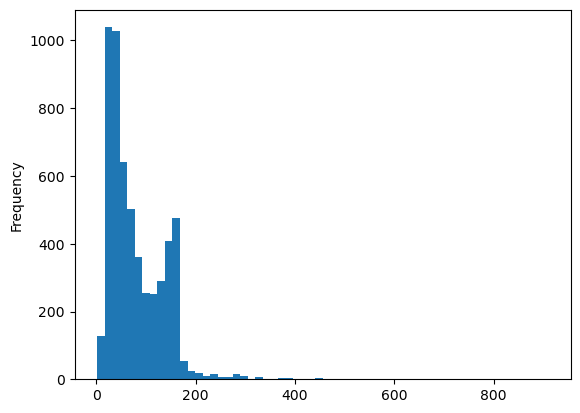

In [106]:
dataset['length'].plot.hist(bins=60)

In [107]:
dataset['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

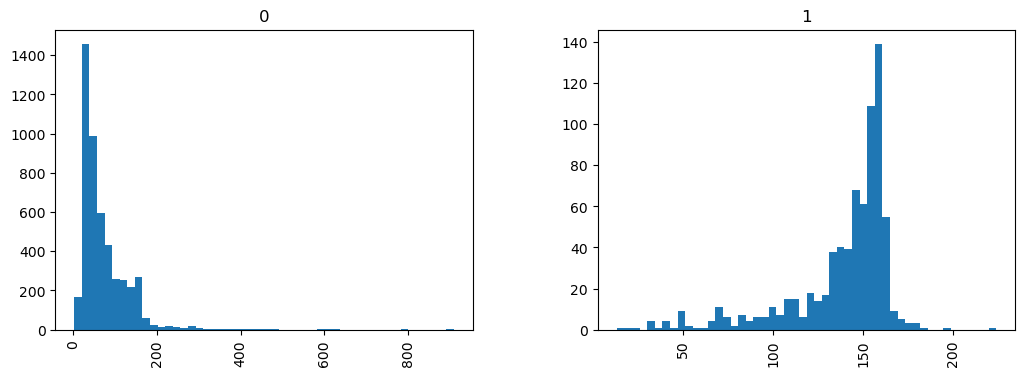

In [108]:
dataset.hist(column='length',by='label',bins=50,figsize=(12,4))

<Axes: xlabel='label', ylabel='length'>

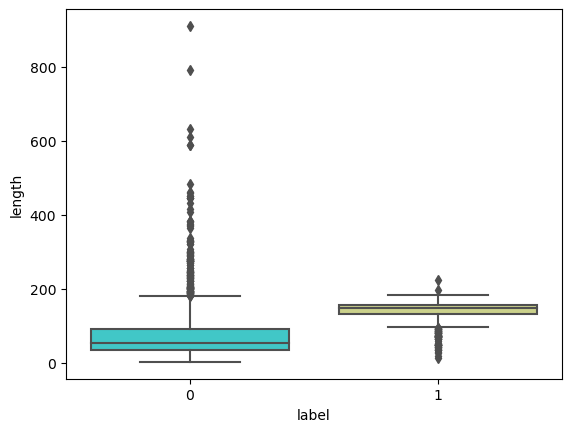

In [109]:
sns.boxplot(x='label',y='length',data=dataset,palette='rainbow')

<Axes: xlabel='label', ylabel='count'>

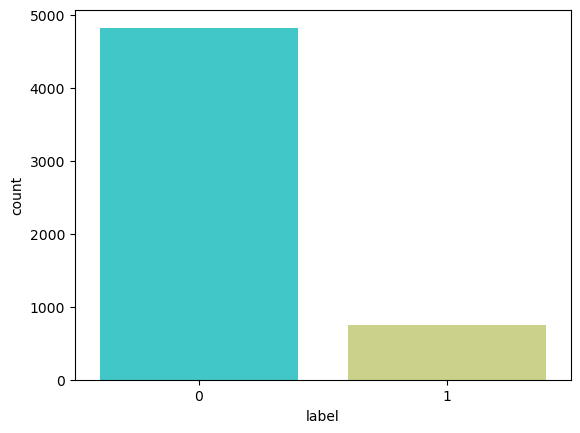

In [110]:
sns.countplot(x='label',data=dataset,palette='rainbow')

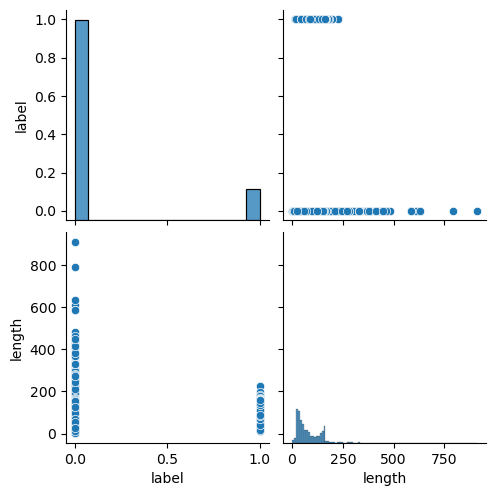

In [111]:
sns.pairplot(dataset)

## Data Cleaning

In [112]:
# Checking for NaN values
dataset.isnull().sum()

label     0
review    0
length    0
dtype: int64

In [113]:
# Checking for empty whitespace strings and assign for an array 
empty_list = []  

for i,label,review,length in dataset.itertuples():  # iterate over the DataFrame
    if type(review)==str:           
        if review.isspace():         
            empty_list.append(i)    
        
len(empty_list)

0

In [114]:
#droping NaN values
dataset.dropna(inplace=True)

In [115]:
#drop empty space values in review 
dataset.drop(empty_list,inplace=True)

In [116]:
# Checking for duplicate values
dataset.duplicated().sum()

403

In [117]:
#remove duplicate entries
dataset.drop_duplicates(keep='first',inplace=True)

In [118]:
#identify the important punctuations
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [119]:
#load english vocabulary
nlp_load = spacy.load("en_core_web_sm")

In [120]:
nlp_load.max_length = 200000

In [121]:
#Create a function to identify the punctuations in each words
def separate_puncuation(doc_text):
    return [token for token in nlp_load(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']


In [122]:
#check wheter there are any single puncuations and convert the row to string
def remove_punctuation_and_convert_to_string(token):
    return ''.join(char for char in str(token) if char not in string.punctuation)

In [123]:
#remove stopwords from each row
def remove_stop(token):
    return [word for word in token.split() if word.lower() not in stopwords.words('english')]

In [124]:
#convert each tokens to string after removing stopwords
def join_list_to_string(lst):
    return ' '.join(lst)

In [125]:
dataset['review'] = dataset['review'].apply(separate_puncuation)

In [126]:
dataset['review'] = dataset['review'].apply(remove_punctuation_and_convert_to_string)

In [127]:
dataset['review'] = dataset['review'].apply(remove_stop)

In [128]:
dataset['review'] = dataset['review'].apply(lambda x: join_list_to_string(x))

In [129]:
dataset['review'] 

0       Go jurong point crazy Available bugis n great ...
1                                 Ok lar Joking wif u oni
2       Free entry 2 wkly comp win FA Cup final tkts 2...
3                     U dun say early hor U c already say
4               Nah nt think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u U å£750 Pound prize...
5568                          Ì b going esplanade fr home
5569                                Pity mood suggestions
5570    guy bitching acted like interested buying some...
5571                                       Rofl true name
Name: review, Length: 5169, dtype: object

In [130]:
#get the values of target data from dataset
target = dataset['label'].values

In [131]:
#get the values of taining data from dataset
train =dataset['review'].values

In [132]:
target.shape

(5169,)

In [133]:
# remove all puctuations (train data)
# remove all stopwords
# create a key value pair for word and vector an store 

token_response = []
word2vec={}
for text in train:
    print(text)
    tokens = separate_puncuation(text)
    for x in tokens:
        #word=x.text
        rem_punc = [single_letter for single_letter in x.text if single_letter not in string.punctuation]
        word=''.join(rem_punc)
        if word.lower() not in stopwords.words('english') :
            vec=np.asarray(x.vector,dtype='float32')
            word2vec[word]=vec
            #print(word)
    token_response.append(tokens)
  


Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat
Ok lar Joking wif u oni
Free entry 2 wkly comp win FA Cup final tkts 21st May 2005 Text FA 87121 receive entry questionstd txt rateTC apply 08452810075over18
U dun say early hor U c already say
Nah nt think goes usf lives around though
FreeMsg Hey darling 3 week word back like fun still Tb ok XxX std chgs send å£150 rcv
Even brother like speak treat like aids patent
per request Melle Melle Oru Minnaminunginte Nurungu Vettam set callertune Callers Press 9 copy friends Callertune
WINNER valued network customer selected receivea å£900 prize reward claim call 09061701461 Claim code KL341 Valid 12 hours
mobile 11 months U R entitled Update latest colour mobiles camera Free Call Mobile Update Co FREE 08002986030
gon na home soon nt want talk stuff anymore tonight k cried enough today
SIX chances win CASH 100 20000 pounds txt CSH11 send 87575 Cost 150p day 6days 16 TsandCs apply Reply HL 4 info
URGENT 1 week FR

Great escape fancy bridge needs lager See tomo
Yes completely formclark also utter waste
Sir need AXIS BANK account bank address
Hmmm Thk sure got time hop ard Ya go 4 free abt Muz call u discuss liao
time coming later
Bloody hell ca nt believe forgot surname Mr Ill give u clue spanish begins
Well gon na finish bath good fine night
Let know got money carlos make call
U still going mall
Turns friends staying whole show wo nt back til ltgt feel free go ahead smoke ltgt worth
Text nt reply let know log
Hi spoke MANEESHA V like know satisfied experience Reply Toll Free Yes
lifted hopes offer money need Especially end month approaches hurts studying Anyways gr8 weekend
Lol U trust
ok gentleman treat dignity respect
guys close
Going nothing greatbye
Hello handsome finding job lazy Working towards getting back net mummy boytoy miss
Haha awesome minute
Please call customer service representative FREEPHONE 0808 145 4742 9am11pm guaranteed å£1000 cash å£5000 prize
got Xmas radio times get
jus re

TODAY Sorry day ever angry ever misbehaved hurt plz plz SLAP URSELF Bcoz ur fault basically GOOD
Yo guys ever figure much need alcohol Jay trying figure much safely spend weed
ltgt ISH MINUTES 5 MINUTES AGO WTF
Thank calling Forgot say Happy Onam Sirji fine remembered met insurance person Meet Qatar Insha Allah Rakhesh ex Tata AIG joined TISSCO Tayseer
Ur cash balance currently 500 pounds maximize ur cash send CASH 86688 150p msg CC 08708800282 HG Suite3422Lands Row W1J6HL
actor work work evening sleep late Since unemployed moment ALWAYS sleep late unemployed every day saturday
Hello got st andrews boy long way cold keep posted
Ha ha cool cool chikku chikkuDB
Oh ok prob
Check audrey status right
Busy Trying finish new year looking forward finally meeting
Good afternoon sunshine dawns day refreshed happy alive breathe air smile think love always
Well know Z take care worries
UpdateNow Xmas Offer Latest Motorola SonyEricsson Nokia FREE Bluetooth Double Mins 1000 Txt Orange Call MobileUpd

Ì come
Check nuerologist
Lolnice went fish water
123 Congratulations week competition draw u å£1450 prize claim call 09050002311 b4280703 TCs stop SMS 08718727868 18 150ppm
waiting e car dat bored wat Cos wait outside got nothing 2 home stuff watch tv wat
Maybe westshore hyde park village place near house
know anthony bringing money school fees pay rent stuff like need help friend need
significance
opinion 1 2 Jada 3 Kusruthi 4 Lovable 5 Silent 6 Spl character 7 matured 8 Stylish 9 Simple Pls reply
8 latest g still scrounge ammo want give new ak try
Prabha im soryda realy frm heart sory
Lol ok forgiven
jst change tat
guaranteed latest Nokia Phone 40 GB iPod MP3 player å£500 prize Txt word COLLECT 83355 IBHltd LdnW15H 150p Mtmsgrcvd18
Sno competition
Boltblue tones 150p Reply POLY MONO eg POLY3 1 Cha Cha Slide 2 Yeah 3 Slow Jamz 6 Toxic 8 Come STOP 4 tones txt
credits topped httpwwwbubbletextcom renewal Pin tgxxrz
way transport less problematic sat night way u want ask n join bday feel 

Sun ca nt come earth send luv rays cloud ca nt come river send luv rain ca nt come meet U send care msg U Gud evng
nt make sense take unless free need know wikipediacom
88800 89034 premium phone services call 08718711108
sea lays rock rock envelope envelope paper paper 3 words
mum repent
Sorry going home first Daddy come fetch Ì later
Leave de Start Prepare next
Yes baby study positions kama sutra
En chikku nange bakra msg kalstiya tea coffee
Carlosll minute still need buy
pay ltDECIMALgt lakhs
good evening Ttyl
u receive msg
Ho ho big belly laugh See ya tomo
SMS ac sun0819 posts HELLOYou seem cool
Get ur 1st RINGTONE FREE Reply msg TONE Gr8 TOP 20 tones phone every week å£150 per wk 2 opt send STOP 08452810071 16
Ditto wo nt worry saying ANYTHING anymore Like said last night whatever want Peace
got ltgt way could pick
nt knw pa drink milk
Maybe Say hi find got card Great escape wetherspoons
Piggy r u awake bet ure still sleeping going 4 lunch
Cause freaky lol
Missed call cause yelling

Also bringing galileo dobby
responding
BOO BABE U ENJOYIN YOURJOB U SEEMED 2 B GETTIN WELL HUNNYHOPE URE OKTAKE CARE IåÕLLSPEAK 2U SOONLOTS LOVEME XXXX
Good afternoon starshine boytoy crave yet Ache fuck sips cappuccino miss babe teasing kiss
road ca nt txt
SMSSERVICES yourinclusive text credits pls goto wwwcomuknet login 3qxj9 unsubscribe STOP extra charge help 08702840625COMUK 220 CM2 9AE
25p 4 alfie Moon Children need song ur mob Tell ur m8s Txt Tone charity 8007 Nokias Poly charity polys zed 08701417012 profit 2 charity
Hmm Bits pieces lol sighs
Hahaha use brain dear
Hey got mail
Sorry light turned green meant another friend wanted ltgt worth may around
Thanks yesterday sir wonderful Hope enjoyed burial MojiBiola
U secret admirer REVEAL thinks U R special Call 09065174042 opt Reply REVEAL STOP 150 per msg recd Cust care 07821230901
Hi mate RV u hav nice hol message 3 say hello coz havenåÕt sent u 1 ages started driving stay roadsRVx
Dear Voucher Holder claim weeks offer PC please g

u want come backa beautiful necklace token heart youthats give WIFE LIKINGBE SEE ONE give thatdont call mei wait till come
willing go aptitude class
wo nt b 215 trying 2 sort house ok
Yar lor wan 2 go c horse racing today mah eat earlier lor ate chicken rice U
Haha awesome omw back
Yup thk e shop closes lor
account number
Eh u send wrongly lar
Hey ad crap nite borin without ya 2 boggy u boring biatch Thanx u wait til nxt time il ave ya
Ok shall talk
nt hesitate know second time weakness like keep notebook eat day anything changed day sure nothing
Hey pay salary de ltgt
Another month need chocolate weed alcohol
started searching get job dayshe great potential talent
Reckon need town eightish walk carpark
Congrats 2 mobile 3 G Videophones R call 09063458130 videochat wid mates play java games Dload polyPH music noline rentl
LOOK FUCKIN TIME FUCK THINK
Yo guess dropped
Carlos says mu ltgt minutes
office call ltgt min
Geeee miss already know think Fuck ca nt wait till next year together lo

want 750 anytime network mins 150 text NEW video phone five pounds per week call 08000776320 reply delivery Tomorrow
Okok ok whats ur todays plan
Good morning princess
Aiyar sorry lor forgot 2 tell u
taking part mobile survey yesterday 500 texts 2 use however wish 2 get txts send TXT 80160 TC wwwtxt43com 150p
tonight mate Catching sleep new number way
Height Oh shit situation guy throws luv letter gal falls brothers head gay
Ur HMV Quiz cash balance currently å£500 maximize ur cash send HMV1 86688 150p msg
check errors difficulties correction
Howz painhope u r fine
U wake already Thanx 4 e tau sar piah quite nice
K need login anything
nt forget place many FREE Requests 1stchoicecouk wish Information call 08707808226
LOL busy
u wearing
Ohas usual vijay film different
nt know u u nt know Send CHAT 86688 let find 150p Msg rcvd HG Suite3422Lands Row W1J6HL LDN 18 years
good day Mine really busy much tomorrow night
way send shade stuff wonderful
Really tot ur paper ended long ago wat u copi

jokin oni lar ÌÏ busy wun disturb Ì
Ok careful nt text drive
Ill always even spirit Ill get bb soon trying sure need
U r much close heart u go away shattered Plz stay
love u 2 babe R u sure everything alrite idiot Txt bak girlie
abt making pics bigger
Got got 2 colours lor One colour quite light n e darker lor Actually done styling hair
Whenevr ur sad Whenevr ur gray Remembr 2 listn 2 watevr u wanna say Jus walk wid little whileamp promise bring back ur smile
nothing Ok anyway give treat
Win newest ÛÏHarry Potter Order Phoenix Book 5 reply HARRY answer 5 questions chance first among readers
Correct work today
sent scream moan bed princess
wake long ago already Dunno thing
Oh getting even u u
thk 50 shd ok said plus minus 10 Ì leave line paragraphs
call plz number shows coveragd area urgnt call vasai amp reach 4o clock call plz
Yeah jay sort fucking retard
Sorry bathroom sup
Ur balance å£500 Ur next question sang Uptown Girl 80 2 answer txt ur ANSWER 83600 Good luck
exam february 4 Wis

Hello lover goes new job happy think wake slave send teasing kiss across sea
told number gautham
Tell need investigate anywhere
Ok juz receive
Ca nt believe said many things morning really wanted say good morning love beautiful morning See library later
account credited 500 FREE Text Messages activate txt word CREDIT 80488 TCs www80488biz
end might still vomit okay everything come
moneY money ai nt thing sha
everything weather Keep extra warm cold nothing serious Pls lots vitamin c
Hey gals Anyone u going e driving centre tmr
always yahoo messenger send message ill get may send mobile mode sha ill get reply
putting ready ltTIMEgt
Time n Smile r two crucial things life Sometimes time makes us forget smile sometimes someone smile makes us forget time gud noon
SMS ac JSco Energy high u may know 2channel 2day ur leadership skills r strong Psychic Reply ANS w question End Reply END JSCO
Host based IDPS linux systems
HOT LIVE FANTASIES call 08707509020 20p per min NTT Ltd PO Box 1327 Croydon

Hi ur lookin 4 saucy daytime fun wiv busty married woman free next week Chat 2 sort time 09099726429 JANINExx Callså£1 minMobsmoreLKPOBOX177HP51FL
mostly like
ÌÏ v fan
Dunno cos v late n reach inside already ate spageddies lor e gals r laughing lor
Guess spent last night phasing fourth dimension
dad gon na call gets work ask crazy questions
Yes said
hurting n meaningful lines ever compromised everything love
Lmaonice 1
Glad see reply
URGENT trying contact U Todays draw shows å£800 prize GUARANTEED Call 09050001295 land line Claim A21 Valid 12hrs
Monthly password wap mobsicom 391784 Use wap phone PC
Nah dub je still buff
Painful words thought Happy toughest thing Earth
Yeah fine å£6 get ok
Lol u come ideas
many people seems special first sight remain special till last sight Maintain till life ends Shjas
Okay wait ah
lei
HI BABE U R LIKELY BED IM SORRY TONIGHT REALLY WANNA SEE U TOMORROW CALL 9 LOVE XXX
Already squatting new way walking
want bold 2 bb torch
Cramps stopped Going back slee

FREE NOKIA Motorola upto 12mths 12price linerental 500 FREE x net mins100txt mth FREE Btooth Call Mobileupd8 08001950382 call 2optout D3WV
nt want hear philosophy say happen
got job wiproyou get every thing life 2 3 years
ca nt get da laptop matric card wif Ì lei
Dunno da next show aft 6 850 Toa payoh got 650
2nd time tried 2 contact u U 750 Pound prize 2 claim easy call 08718726970 10p per min BT national rate
made payments nt much Sorry Would want fedex way
didt play one day last year know even though good team Like india
Kyou girl waiting reception ah
Say slowly GOD LOVE amp NEED CLEAN HEART BLOODSend Ten special people amp u c miracle tomorrow pls pls
hate turns fun shopping trip annoying day everything would look house
Sir waiting call
want come online
could work reach consensus next meeting
Aiyah wait lor u entertain Hee
last thing ever wanted hurt nt think would laugh embarassed delete tag keep going far knew nt even fact even felt like would hurt shows really nt know messy wedn

Simply sitting watching match office
jot things want remember later
Oh sorry please
Hey going lo lesson gym
nt pack buy storelike cereals must pack food pack gari something 9ja miss
always make things bigger
ÌÏ dun wan watch infernal affair
waking 4 afternoon sup
send pic like
Okay booked already Including one bugis
Aight fuck get later
de call time Ill tell k
nt use hook
much blackberry bold2 nigeria
Hi home calicut
Hey darlin pick u college u tell wen 2 mt love Pete xx
Call 09094100151 use ur mins Calls cast 10p min mob vary Service provided AOM GBP5 month AOM Box61M60 1ER u stop Ages 18
Oh thkin goin yogasana 10 den nd go 3 den rush parco 4 nb Okie lor u call ready
late need go n get da laptop
Sir waiting mail
Please charge mobile get morning
Nothing got msg frm tht unknown
Ugh fuck resubbing eve
nt see shadow get early spring yay
One slice one breadstick Lol
Hey want crave miss need love Ahmad Saeed al Hallaq
training tomorrow
URGENT mobile å£2000 Bonus Caller Prize 020603 2nd atte

Alrite jod revision goin Keris bin doin smidgin N e way u wanna cum collegexx
belive Come home
Oh kk take test
exact intentions
haha money leh Later got go tuition Haha looking empty slots driving lessons
Hey Thk juz go accordin wat discussed yest lor except kb sun Cos nt much lesson go attend kb sat
K wen ur free come home also tel vikky hav sent mail also Better come evening il free today aftr 6pm
Nothing getting msgs dis name wit different
room number Wanna make sure knocking right door
Sicomo nolistened2the plaid album quite gdthe new air1 hilarious also boughtåÓbraindanceåÓa compofstuff aphexåÕs abel
Pls tell nelson bb longer comin money expecting ai nt coming
Give something drink takes nt vomit temp might drop unmits however let know
Think sent text home phone ca nt display texts still want send number
Every day use sleep ltgt
K call close
U buy newspapers already
Nope wif sis lor Aft bathing dog bathe Looks like going 2 rain soon
Boo way moms making tortilla soup Yummmm
manageme

wiskey Brandy Rum Gin Beer Vodka Scotch Shampain Wine KUDIyarasu dhina vaazhthukkal
Boo things back home little bored already
First gained ltgt kg since took Second done blood sugar tests ok blood pressure within normal limits worries
PICK UR FONE U DUMB
Thanks da thangam feel happy dear also miss da
Okey doke home dressed cos laying around ill Speak later bout times stuff
nt run away frm u walk slowly amp kills u nt care enough stop
Babe back Come back
Well told others marry
Neshanth tel r u
YO YO YO BYATCH WHASSUP
Oh Kay sat right
Hi Roger CL
Babe U want nt u baby nasty thing 4 filthyguys Fancy rude time sexy bitch go slo n hard Txt XXX SLO4msgs
Oh oh Wasted Den muz chiong sat n sun liao
Jesus christ bitch trying give drugs answer fucking phone
Please give 2 pick Tuesday evening 8 ok
meeting Darren
One best dialogue cute reltnship Wen Die
Solve Case Man Found Murdered ltDECIMALgt ltgt AfterNoon 1His wife called Police 2Police questioned everyone 3Wife Sir sleeping murder took place 4

sch neva mind u eat 1st lor
Hey U sleeping morning
Erm thought contract ran the4th october
dunno Lets go learn pilates
U subscribed best Mobile Content Service UK å£3 per ten days send STOP 83435 Helpline 08706091795
Yup elaborating safety aspects issues
3 FREE TAROT TEXTS Find love life TRY 3 FREE Text CHANCE 85555 16 3 Free Msgs å£150
Goodmorning today late 1hr
Hi happy birthday Hi hi hi hi hi hi hi
outside office take
nt respond imma assume still asleep imma start calling n shit
Aight see bit
superior telling friday leave department except oursso leave youany way call waheed fathima hr conform
Join UK horniest Dogging service u sex 2nite sign follow instructions Txt ENTRY 69888 Nyt EC2A3LPmsg150p
Lol take member said aunt flow nt visit 6 months cause developed ovarian cysts Bc way shrink
Still work going onit small house
friend got says upping order grams got ltgt get
Tmr timin still da wat cos got lesson 6
ThatÛ÷s thing apes u fight death keep something minute u let go
gon na able

Well might come
Long quit get like 5 minutes day
likely called Mittelschmertz Google nt paracetamol nt worry go
Well right gon na get check today steam sales pee text want come get
arrived see couple days lt3
K wat tht incident
Yeah get unlimited
cThen thk shd b enuff Still got conclusion n contents pg n references b da contents pg n cover pg
Forgot takes 3 years shower sorry phone dead yet
ÌÏ got wat buy tell us Ì need come
big God bring success
UÛªve Bin Awarded å£50 Play 4 Instant Cash Call 08715203028 Claim EVERY 9th Player Wins Min å£50 å£500 OptOut 08718727870
Û r stayin extra week back next rugby weekend Hi c u soon ham
campus library
affidavit says ltgt E Twiggs St division g courtroom ltgt ltTIMEgt double check text tomorrow
creep
get ten billion calls texts help god
told returned order
House Maid murderer coz man murdered ltgt th January public holiday govtinstituitions closed including post office
Depends u going lor
smile right go world wonder smiling think crazy keep awa

Xmas Offer Latest Motorola SonyEricsson Nokia FREE Bluetooth DVD Double Mins 1000 Txt Orange Call MobileUpd8 08000839402 call2optout4QF2
u mean u almost done Done wif sleeping tot u going take nap Yup send liao picking ard 4 smth lor
Tonight Yeah
eat fo lunch senor
said right giggle saw u would possibly first person2die NVQ think much could
break time one come n get stuff fr Ì
Reply win å£100 weekly professional sport Tiger Woods play Send STOP 87239 end service
see ca nt see Maybe reboot ym seen buzz
still grinder
1 POLYPHONIC tone 4 ur mob every week txt PT2 87575 1st Tone FREE get txtin tell ur friends 150p tone 16 reply HL 4info
Ki didt see youkwhere
list buyers
idea guess work hour supposed leave since usual nobody interest figuring shit last second
Mm entirely sure understood text hey Ho weekend
released vday shirts u put makes bottom half naked instead white underwear
know watching film computer
b4 Thursday
Oh phone phoned disconnected
onluy matters getting offcampus
message fre

X2 ltgt going get
Hi neva worry bout da truth coz truth lead 2 ur heart ItåÕs least unique person like u deserve Sleep tight morning
UR awarded City Break could WIN å£200 Summer Shopping spree every WK Txt STORE 88039SkilGme TsCs087147403231WinawkAge16å£150perWKsub
ur paper today e morn aft
lick every drop ready use mouth well
expect whenever text Hope goes well tomo
Great P diddy neighbor comes toothpaste every morning
av new number Wil u use one ta
poking man everyday teach canada abi saying hi
7 lor Change 2 suntec Wat time u coming
deam seeing online shop asked
curious cuz asked
Okay lor Wah like def wo nt let us go Haha say terms conditions
Haha Yup hopefully lose kg mon hip hop go orchard weigh
good r u working
Oh yes little weather kind coccooning home
home also
phone weirdest auto correct
Oops phone died nt even know Yeah like better
nt mus ask u 1st wat meet 4 lunch den u n meet already lor u wan 2 go ask da ge 1st confirm w asap
said u mind go bedroom minute OK sed sexy mood 

K Must book huh going yoga basic sunday
FREE MSG billed mobile number mistake shortcode 83332Please call 08081263000 charges refunded call free BT landline
Ok
Oops mum somerset Bit far Back tomo see soon x
u workin overtime nigpun
kallis dismissial 2nd test
Guess got screwd
Please CALL 08712402972 immediately urgent message waiting
r u cooking dinner
Bull plan go floating IKEA without care world live mess another day
buy
URGENT Mobile number awarded å£2000 Bonus Caller Prize Call 09058095201 land line Valid 12hrs
Heehee funny tho
simple arithmetic percentages
Yeah would nt leave hour least 4 sound
Thanks honey great day
Amazing Quote Sometimes life difficult decide wrong lie brings smile truth brings tear
Ì ask dad pick Ì lar ÌÏ wan 2 stay 6 meh
Jus chillaxin
HEY DAS COOL IKNOW 2 WELLDA PERIL STUDENTFINANCIAL CRISISSPK 2 U L8R
want New Nokia 3510i colour phone DeliveredTomorrow 300 free minutes mobile 100 free texts Free Camcorder reply call 08000930705
coming hill monster Hope great d

Rock yr chik Get 100 filthy films XXX pics yr phone rply FILTH 69669 Saristar Ltd E14 9YT 08701752560 450p per 5 days Stop2 cancel
got like ltgt get later though Get whatever feel like
Dad wanted talk apartment got late start omw
love
Lol u still feeling sick
Din tell u jus 420
eyes philosophy
next month get upto 50 Calls 4 Ur standard network charge 2 activate Call 9061100010 C Wire3net 1st4Terms PoBox84 M26 3UZ Cost å£150 min MobcudB
Ok lor town lei
already sabarish asked go
da Vijay going talk jaya tv
URGENT trying contact U Todays draw shows å£800 prize GUARANTEED Call 09050000460 land line Claim J89 po box245c2150pm
Lol know Hey someone great inpersonation flea forums love
Text BANNEDUK 89555 see cost 150p textoperator g696ga 18 XXX
Still chance search hard get let try
Auction round 4 highest bid å£54 Next maximum bid å£71 bid send BIDS e g 10 bid å£10 83383 Good luck
always celebrate NY family
know TAJ MAHAL symbol love lesser known facts 1 Mumtaz Shahjahan 4th wife 7 wifes 2 Sha

stopped get ice cream go back
stitch trouser
22 146tf150p
Hey bored thinking u wat r u
Nah Wednesday bring mini cheetos bag
Nobody names penis girls name story nt add
Aight let know gon na around usf
lip synced shangela
ÌÏ neva tell noe home da aft wat
bit Ur smile hppnss drop Ur tear sorrow part Ur heart life heart like mine wil care U forevr GOODFRIEND
Dear Voucher Holder 2 claim 1st class airport lounge passes using holiday voucher call 08704439680 booking quote 1st class x 2
Buzz Hey Love think hope day goes well sleep miss babe long moment together againloving smile
Haha Sounds crazy dunno tahan anot
u early
Ya one slow poo
Im gloucesterroad uup later
Lol ouch wish stayed bit longer
GOD ASKED forgiveness little child gave lovely reply
join ltgt bus
ask keep one Maybe nt get messages sent glo
Ki send ltgt min
Would smoking help us work difficult time
Someone U know asked dating service 2 contact Ca nt guess CALL 09058095107 revealed POBox 7 S3XY 150p
Yesmum lookin strong
Sir Goodmo

Ì wan go C doctor
daddy bb
Free Msg get Gnarls Barkleys Crazy ringtone TOTALLY FREE reply GO message right
borderline yeah whatever
545 lor Ya go 4 dinner together
gentle princess make sweet gentle love
u doin baby girl hope u okay every time call ure phone miss u get touch
Sorry went bed early nightnight
like think always possibility pub later
HMM yeah grooved looking forward pound special
got video tape pple type message lor U free wan 2 help Hee Cos noe u wan 2 watch infernal affairs ask u along Asking shuhui oso
Hi dude hw r u da realy mising u today
hungry buy food good lei mum n yun dun wan juz buy little bit
Refused loan Secured Unsecured Ca nt get credit Call free 0800 195 6669 text back help
probably wo nt eat today think gon na pop weekend u miss
knew U slept v late yest Wake late
Haha nt angry Take practice real thing
one day training
could kiss feel next
nice day dear
sent lanre fakeye Eckankar details mail box
dad back ph
specially selected receive 3000 award Call 08712402

Yo gon na still stock tomorrow today trying get dubsack
URGENT Mobile number awarded UKP2000 prize GUARANTEED Call 09061790125 landline Claim 3030 Valid 12hrs 150ppm
see prolly yeah
Thought could go dinner treat Seem ok
stand away nt heart ache without nt wonder nt crave
Sorry never hear unless book One kinda joke thet really looking skinny white girls one line much camera Something like casting look
Sure thing big man hockey elections 6 shouldnÛ÷t go longer hour though
Watch lor saw swatch one thk quite ok Ard 116 need 2nd opinion leh
Hiya u like hlday pics looked horrible took mo camp Amrca thing Speak soon Serena
Babe goes day miss already Love loving kiss hope everything goes well
Yunny goin late
Doc prescribed morphine cause pain meds nt enough Waiting mom bring med kick fast gon na try later
Cool want go kappa meet outside mu
Hey sexy buns told adore loverboy hope remember thank sister law meatballs grins love babe
May b approve panalam posts
SPJanuary Male Sale Hot Gay chat che

pocked
Congrats great wanted tell tell score cos might make relax motivating thanks sharing
wud never mind u nt miss u nt need u wil really hurt wen u need amp u nt tell Take care
Hey mr name bill brison book one language words
Okay good problem thanx
information IKEA spelled caps yelling thought left sitting bed among mess came said going got home class please nt try bullshit makes want listen less
Call ure done
GWR
best watch say cause get drunk motherfucker
Kit Strip billed 150p Netcollex Ltd PO Box 1013 IG11 OJA
Please CALL 08712402578 immediately urgent message waiting
thesmszonecom lets send free anonymous masked messages im sending message see potential abuse
Erm Woodland avenue somewhere get parish magazine telephone number
TA jobs available Let know please cos really need start working
Aiyar hard 2 type U later free tell call n scold n tell u
Yup free
Good good billy mates gone jogging enjoy concert
Yo come carlos soon
Awww dat sweet think something nice time tonight ill proba

pick 515pm go taunton still want come
Oh 4 outside players allowed play know
anything lor
Erutupalam thandiyachu
ca nt u try new invention fly im joking
ful song lyrics
u reckon need 2 arrange transport u ca nt thanks
True lov n care wil nevr go unrecognized though somone often makes mistakes valuing definitly undrstnd start missing
Shopping Eh ger toking abt syd leh Haha
standing
good weekend
Miss call miss call khelate kintu opponenter miss call dhorte lage rule One great phone receiving quality wins
Call get chance plz lt3
new deus ex game comin early next yr
computer fried essential part nt keep spares fucking idiot roommates looovvve leaving thing running full ltgt 7
friend studying warwick planned go shopping concert tmw may canceled havnt seen ages yeah get together sometime
Probably couple hours tops
LOL grins babe thanks thinking
Man bus slow think gon na get
Hope text meets smiling let text give reason smile beautiful day
case wake wondering forgot take care something grandma

leaving house
Hi babe Chloe r u smashed saturday night great weekend U missing SP visionsmscom Text stop stop 150p text
ÌÏ ready call
Wewa 130 Iriver 255 128 mb
good thing getting connection bw
Sry da jst nw came home
cool night lemme know around
staying town
Haha yeah 2 oz kind shitload
Ok u take shopping u get paid
Alright bring see like ltgt mins
pls nt play others life
Eatin lunch
Hmmmbut give one day
nt try g decided head
Ok prob
Surly ill give coming review
march ending ready call sure problem capital never complete far work ladies
Pls give food preferably pap slowly loads sugar take hour give water slowly
URGENT Mobile 07808726822 awarded å£2000 Bonus Caller Prize 020903 2nd attempt contact Call 0871 872 9758 BOX95QU
guy gets used dumb realize
Okey dokey iÛ÷ll bit sorting stuff
Yes fine
liked new mobile
Anytime
Mmmmmmm snuggles deep contented sigh whispers fucking love much barely stand
Yar say got error
Hey anyway
Wow healthy Old airport rd lor Ca nt thk anything else b bathin

many things antibiotic used chest abdomen gynae infections even bone infections
Poor girl ca nt go one day lmao
6times
pls make note shes exposed Also find school anyone else vomiting dog cat house Let know later
Sounds like could lot time spent chastity device boy grins take beatings like good dog Going lounge nice long bath
worse uses half way stops better complete
Miserable nt tell u side effects birth control massive gut wrenching cramps first 2 months nt sleep last night
Send new number
Want latest Video handset 750 anytime network mins Half price line rental Reply call 08000930705 delivery tomorrow
2 half years missed friendship
Oh fuck sake like tallahassee
Haha first person gon na ask
ou guaranteed latest Nokia Phone 40 GB iPod MP3 player å£500 prize Txt word COLLECT 83355 IBHltd LdnW15H 150p Mtmsgrcvd18
Taka lor Wat time u wan 2 come n look 4 us
FREE POLYPHONIC RINGTONE Text SUPER 87131 get FREE POLY TONE week 16 SN PoBox202 NR31 7ZS subscription 450pw
Im reaching another 2 st

Mark works tomorrow gets 5 work house meet u afterwards
Keep ur problems ur heart
Yeah give call got minute
HI BABE UAWAKEFEELLIKW SHITJUSTFOUND VIA ALETTER THATMUM GOTMARRIED 4thNOVBEHIND OURBACKS åÐ FUCKINNICESELFISH
Amazing rearrange letters gives meaning Dormitory Dirty room Astronomer Moon starer eyes see Election results Lies lets recount Mother law Woman Hitler Eleven plus two Twelve plus one Amazing
Aiya discuss later lar Pick Ì 4
Hey happy birthday
Sorry missed call please call back
Omg one thing another cat worms bad day end
Good morning suffering fever dysentry able come office today
wo nt anything de
type stuff sing
St andre virgil cream
fri ah Okie lor goin 4 drivin den go shoppin tt
Gokila talking aha
Hi Shanil Rakhesh herethanks exchanged uncut diamond stuffleaving back Excellent service Dino Prem
Kkthis month kotees birthday know
really really broke oh amount small even ltgt
Sorry mates phone nt write love Kate
TheMob Hit link get premium Pink Panther game new 1 Sugabab

gone get info bt nt know
Yeah probably
still pretty weak today Bad day
Hey nt forget MINE possession property MMM childish smile
excellent thought misundrstud frnd knw u hate bt day wen ull knw truth ull hate urself Gn
Hey Congrats 2u2 luv 2 2 go home
Dear Call
Xy trying smth U eat already nt
Urgent Please call 09061213237 landline å£5000 cash luxury 4 Canary Islands Holiday await collection TCs SAE PO Box 177 M227XY 150ppm 16
donno genes something
XMAS iscoming ur awarded either å£500 CD gift vouchers free entry 2 r å£100 weekly draw txt MUSIC 87066 TnC www Ldewcom1win150ppmx3age16subscription
Alex says ok ok
u coming funeral home
darling sister school resuming minimum wait period reapply take care
Ill hand phone chat wit u
Well good morning mr london treatin ya treacle
ca nt make tonight
ltgt bucks banks fees fixed Better call bank find
tell quite long cos nt finish film yet
Pls ask macho much budget bb bold 2 cos saw new one ltgt dollars
Hi missed Call mumHas beendropping red wine t

thought slide enough
Well obviously people cool college life went home
Ok lor Ì reaching message
mummy boy good bad positive negative mummy made wait Hmmmm
Dhoni luck win big titleso win
Yes princess want please every night wish command
probably ltgt
Really hope work nt get stressful gr8 day
seen back Holby
Shall call dear food
URGENT trying contact Last weekends draw shows u å£1000 prize GUARANTEED Call 09064017295 Claim code K52 Valid 12hrs 150p pm
li hai bored da lecturer repeating last weeks stuff waste time
picking various points going 2 yeovil motor project 4 3 hours u take home 12 2 530 max easy
Also fuck family going rhode island wherever fuck leaving alone week new bong gt
Ofcourse also upload songs
2p per min call Germany 08448350055 BT line 2p per min Check PlanetTalkInstantcom info C Text stop opt
Oh thanks lot already bought 2 eggs
U studying sch going home Anyway b going 2 sch later
Marvel Mobile Play official Ultimate Spider man game å£450 ur mobile right Text SPIDER 833

In [134]:
word_list = list(word2vec.keys())

In [135]:
#display allwords after removing stopwords
word_list

['Go',
 'jurong',
 'point',
 'crazy',
 'Available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'Cine',
 'got',
 'amore',
 'wat',
 'Ok',
 'lar',
 'Joking',
 'wif',
 'u',
 'oni',
 'Free',
 'entry',
 '2',
 'wkly',
 'comp',
 'win',
 'FA',
 'Cup',
 'final',
 'tkts',
 '21st',
 'May',
 '2005',
 'Text',
 '87121',
 'receive',
 'questionstd',
 'txt',
 'rateTC',
 'apply',
 '08452810075over18',
 'U',
 'dun',
 'say',
 'early',
 'hor',
 'c',
 'already',
 'Nah',
 'nt',
 'think',
 'goes',
 'usf',
 'lives',
 'around',
 'though',
 'FreeMsg',
 'Hey',
 'darling',
 '3',
 'week',
 'word',
 'back',
 'like',
 'fun',
 'still',
 'Tb',
 'ok',
 'XxX',
 'std',
 'chgs',
 'send',
 'å£150',
 'rcv',
 'Even',
 'brother',
 'speak',
 'treat',
 'aids',
 'patent',
 'per',
 'request',
 'Melle',
 'Oru',
 'Minnaminunginte',
 'Nurungu',
 'Vettam',
 'set',
 'callertune',
 'Callers',
 'Press',
 '9',
 'copy',
 'friends',
 'Callertune',
 'WINNER',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'å£

In [136]:
word2vec

{'Go': array([-0.76250696, -0.60188293,  0.1627016 ,  0.92800957,  0.39675826,
        -0.6340611 , -0.7754165 ,  0.301865  , -0.38565224,  0.0095194 ,
         0.06223448,  0.07890677, -1.0263233 , -1.0083964 , -0.139337  ,
         0.5412644 , -0.34157246,  0.32580292, -1.0158558 , -0.5308713 ,
        -0.45682448,  0.66252637, -1.6292144 ,  0.1810083 ,  0.03026973,
        -1.029876  ,  0.14345099,  1.0510976 , -0.5310776 ,  0.52588034,
        -0.6845734 ,  1.0049257 ,  0.27807537,  0.45042497,  0.6429097 ,
         0.06196234,  0.69571584, -0.05681758, -0.6717957 , -0.8531884 ,
         0.20441274, -1.4939084 ,  0.32523316, -0.93924606, -0.41445035,
         0.3778335 ,  1.8780761 , -0.1129961 ,  0.66109973, -0.12485963,
        -0.16104172,  0.39735332, -1.5999122 , -0.8229501 ,  1.0294031 ,
        -0.06379022, -0.5263369 , -0.03126341,  0.36145163, -0.14578259,
        -0.61474615,  0.74901235, -0.16898969,  0.7164674 ,  0.02245557,
        -0.22643921, -0.21828593, -0.18205246

## Tokenization

In [137]:
#initialize constans
sequece_length = 96
vocabulary_size = 20000
embedding_dim = 96
validation_split = 0.2
batch_size = 128
epochs = 10

In [138]:
#convert the sentence to integer
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(train)
sequences = tokenizer.texts_to_sequences(train)

In [139]:
sequences

[[7,
  3747,
  630,
  563,
  564,
  1027,
  35,
  55,
  312,
  1028,
  73,
  2470,
  1029,
  12,
  3748,
  57],
 [9, 196, 1177, 313, 1, 1560],
 [11,
  408,
  4,
  840,
  841,
  128,
  2471,
  1178,
  565,
  2472,
  2473,
  168,
  2474,
  21,
  2471,
  2475,
  246,
  408,
  3749,
  31,
  3750,
  325,
  3751],
 [1, 133, 75, 237, 2476, 1, 77, 67, 75],
 [771, 2, 36, 326, 713, 1561, 110, 314],
 [592,
  48,
  1344,
  98,
  52,
  238,
  30,
  14,
  270,
  29,
  1562,
  9,
  254,
  1179,
  3752,
  22,
  375,
  2477],
 [126, 489, 14, 271, 519, 14, 3753, 3754],
 [146,
  1345,
  2478,
  2478,
  2479,
  3755,
  3756,
  3757,
  490,
  1563,
  2480,
  1180,
  327,
  1181,
  176,
  1563],
 [631,
  842,
  328,
  156,
  363,
  3758,
  1182,
  76,
  843,
  63,
  3,
  3759,
  63,
  297,
  3760,
  395,
  714,
  463],
 [44,
  926,
  844,
  1,
  34,
  1183,
  445,
  247,
  464,
  845,
  298,
  11,
  3,
  44,
  445,
  1564,
  11,
  3761],
 [124, 101, 27, 129, 2, 19, 169, 170, 927, 120, 60, 3762, 315, 32],
 [

In [140]:
#word integer mapping
word_index = tokenizer.word_index

In [141]:
#pad sequences to create NxT matrix
ps_data = pad_sequences(sequences , maxlen=sequece_length)

In [142]:
ps_data.shape

(5169, 96)

In [143]:
#creating Embedded matrix
number_words = min(vocabulary_size,len(word_index)+1)

In [144]:
em_matrix = np.zeros((number_words,embedding_dim))

In [145]:
for word,i in word_index.items():
    if i < vocabulary_size:
        em_vector = word2vec.get(word)
        if em_vector is not None:
            em_matrix[i] = em_vector

In [146]:
embedding = Embedding(
    number_words,
    embedding_dim,
    weights=[em_matrix],
    input_length=sequece_length,
    trainable=False
)

## Create Lstm Model

In [147]:
#create lstm model 
input =Input(shape=(sequece_length,))
lstm=embedding(input)
lstm=LSTM(32, return_sequences=True)(lstm)
lstm=GlobalMaxPool1D()(lstm)
output = Dense(1,activation='sigmoid')(lstm)

In [148]:
model = Model(input,output)

In [149]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.01),metrics=['accuracy'])

In [150]:
#model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 96, 96)            864576    
                                                                 
 lstm_2 (LSTM)               (None, 96, 32)            16512     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 881121 (3.36 MB)
Trainable params: 16545 (64.63 KB)
Non-trainable params: 864576 (3.30 MB)
____________________

In [151]:
model_history = model.fit(ps_data,target,batch_size=batch_size,epochs=epochs,validation_split=validation_split)

Epoch 1/10
33/33 [==============================] - 4s 63ms/step - loss: 0.2542 - accuracy: 0.9132 - val_loss: 0.1182 - val_accuracy: 0.9710
Epoch 2/10
33/33 [==============================] - 2s 51ms/step - loss: 0.1057 - accuracy: 0.9715 - val_loss: 0.0749 - val_accuracy: 0.9807
Epoch 3/10
33/33 [==============================] - 2s 49ms/step - loss: 0.0666 - accuracy: 0.9838 - val_loss: 0.0617 - val_accuracy: 0.9836
Epoch 4/10
33/33 [==============================] - 2s 48ms/step - loss: 0.0457 - accuracy: 0.9889 - val_loss: 0.0546 - val_accuracy: 0.9826
Epoch 5/10
33/33 [==============================] - 2s 48ms/step - loss: 0.0327 - accuracy: 0.9927 - val_loss: 0.0547 - val_accuracy: 0.9816
Epoch 6/10
33/33 [==============================] - 2s 48ms/step - loss: 0.0274 - accuracy: 0.9932 - val_loss: 0.0587 - val_accuracy: 0.9826
Epoch 7/10
33/33 [==============================] - 2s 51ms/step - loss: 0.0250 - accuracy: 0.9937 - val_loss: 0.0753 - val_accuracy: 0.9749
Epoch 8/10
33

### Loss

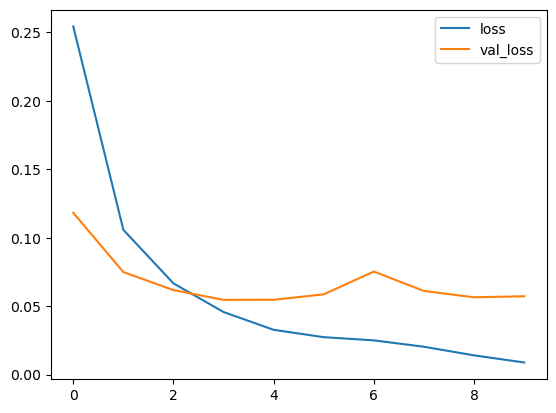

In [152]:
plt.plot(model_history.history['loss'],label='loss')
plt.plot(model_history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

### Accuracy

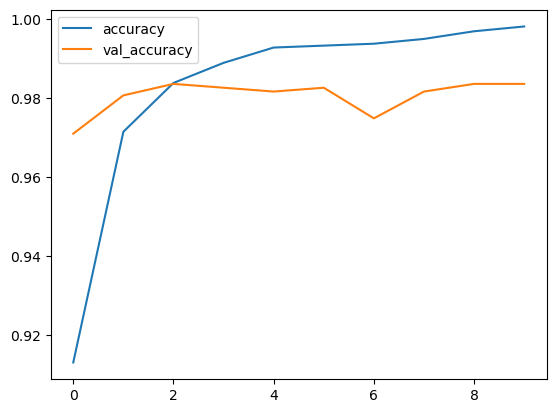

In [153]:
plt.plot(model_history.history['accuracy'],label='accuracy')
plt.plot(model_history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [154]:
prediction=model.predict(ps_data)

162/162 [==============================] - 2s 10ms/step


In [155]:
threshold_value = 0.5

In [156]:
prediction_summary = (prediction > threshold_value).astype(int)

In [157]:
concatenated_array = np.concatenate((target.reshape(len(target), 1), prediction_summary.reshape(len(prediction_summary), 1)), 1)

In [158]:
np.set_printoptions(threshold=np.inf)

In [159]:
concatenated_array

array([[0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0,

In [160]:
common_words = FreqDist(word_list).most_common(50)

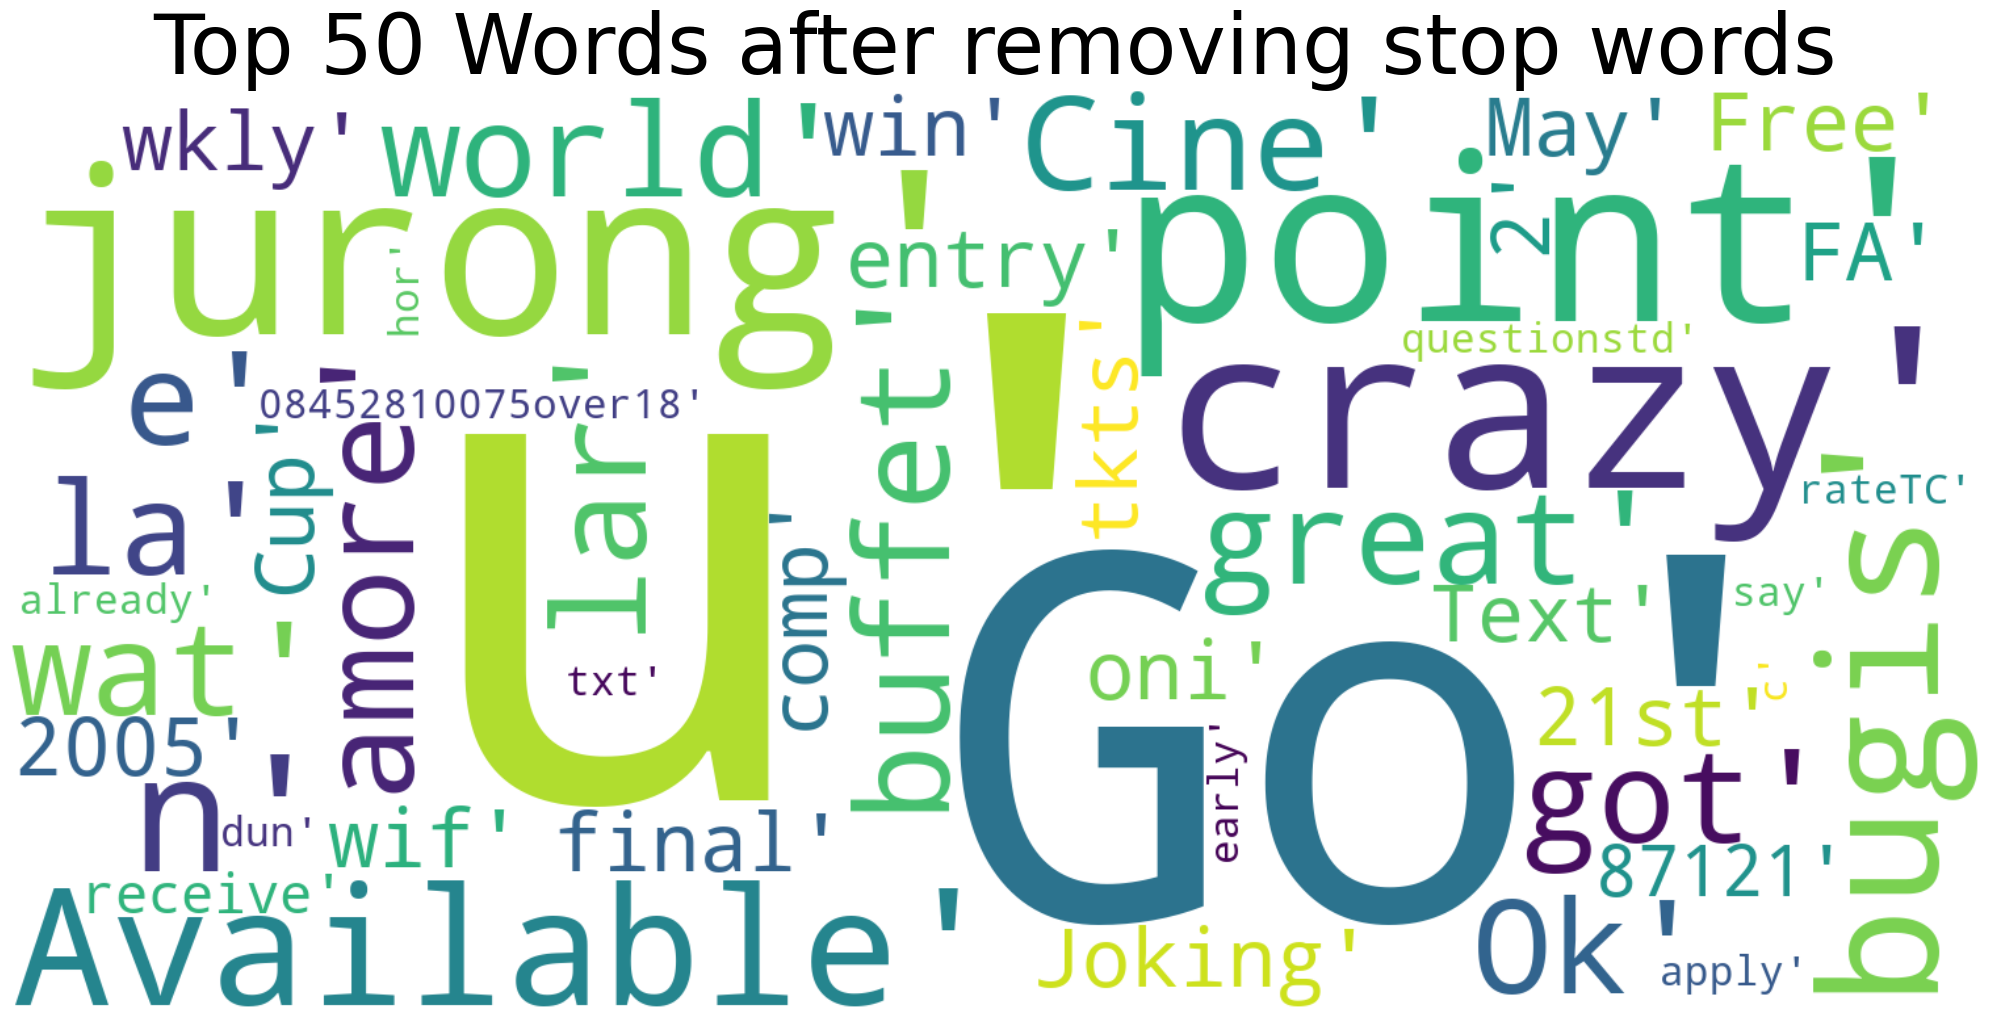

In [161]:

wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(str(common_words))
fig = plt.figure(figsize=(40,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words after removing stop words', fontsize=60)
plt.tight_layout(pad=0)
plt.show()


## Performance Metrics

In [169]:
from keras.metrics import Precision, Recall ,Accuracy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score

In [170]:
#AUC Score
roc =roc_auc_score(target,prediction)
print("ROC_AUC_SCORE:", roc)

ROC_AUC_SCORE: 0.9988890953655336


In [171]:
#Root Mean Squared Error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(target, prediction_summary))
print("RMSE:", rmse)

RMSE: 0.06670534764854996


In [172]:
#Mean Squared Error
mse = mean_squared_error(target, prediction_summary)
print("MSE:", mse)

MSE: 0.00444960340491391


In [173]:
# Create Precision and Recall metrics
precision = Precision()
recall = Recall()
accuracy = Accuracy()

precision.update_state(target, prediction_summary)
recall.update_state(target, prediction_summary)
accuracy .update_state(target, prediction_summary)


precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()


In [174]:
# display precision and recall values
print(f"Precision: {precision_result}")
print(f"Recall: {recall_result}")
print(f"Accuracy: {accuracy_result}")

Precision: 0.9876161217689514
Recall: 0.9770290851593018
Accuracy: 0.9955503940582275


In [175]:
print(classification_report(target, prediction_summary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4516
           1       0.99      0.98      0.98       653

    accuracy                           1.00      5169
   macro avg       0.99      0.99      0.99      5169
weighted avg       1.00      1.00      1.00      5169



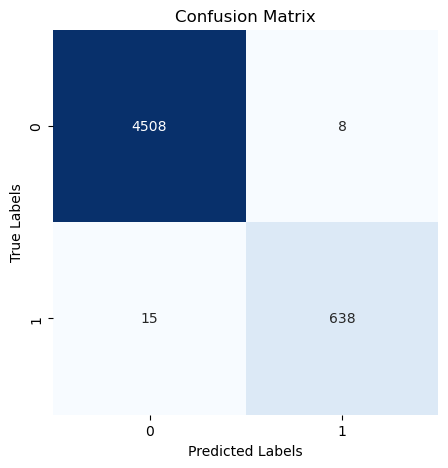

In [176]:
cm = confusion_matrix(target, prediction_summary)

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()